In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark=SparkSession.builder.appName("exemplo bla bla").config("spark.driver.memory","4g").config("spark.executor.memory","4g").getOrCreate()

23/03/23 20:21:17 WARN Utils: Your hostname, IC1019-1 resolves to a loopback address: 127.0.1.1; using 172.30.15.89 instead (on interface eth0)
23/03/23 20:21:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/23 20:21:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/23 20:21:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/03/23 20:21:19 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [ ]:
# Some general imports 

import os
import sys

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
# from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def plotHistogram(df, xcol, huecol=None):
    sns.histplot(data=df, x=xcol, hue=huecol, multiple="stack")

In [ ]:
def plot(df, xcol, ycol):
    sns.lineplot(data=df, x=xcol, y=ycol)

In [ ]:
def plotBar(df, xcol, ycol, huecol=None):
    sns.barplot(data=df, x=xcol, y=ycol, hue=huecol)

In [ ]:
def plotScatter(df, xcol, ycol, huecol=None):
    sns.scatterplot(data=df, x=xcol, y=ycol, hue=huecol)

In [ ]:
def plotScatterMatrix(df, huecol=None):
    sns.pairplot(data=df, hue=huecol)

In [ ]:
def plotCorrelationMatrix_1(df, annot=False):
    # compute the correlation matrix
    corr = df.corr()
    
    # generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    #cmap='coolwarm'

    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=annot,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
def plotCorrelationMatrix_2(df):
    # compute a correlation matrix and convert to long-form
    corr_mat = df.corr().stack().reset_index(name="correlation")
    # draw each cell as a scatter point with varying size and color
    g = sns.relplot(
        data=corr_mat,
        x="level_0", y="level_1", hue="correlation", size="correlation",
        palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
        height=10, sizes=(50, 250), size_norm=(-.2, .8),
    )

    # tweak the figure to finalize
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    for artist in g.legend.legendHandles:
        artist.set_edgecolor(".7")

In [ ]:
# Some Spark related imports we will use hereafter

import sys

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
filename = "train.csv"
df_train = spark.read.csv(filename,header=True, sep=",", inferSchema=True)


In [ ]:
filename = "test.csv"
df_teste = spark.read.csv(filename,header=True, sep=",", inferSchema=True)

In [ ]:
filename = "train_labels.csv"
df_train_labs = spark.read.csv(filename,header=True, sep=",", inferSchema=True)

In [ ]:
df_teste.printSchema()
df_teste.show(1, vertical=True)
teste_count = df_teste.count()
df_teste.show(1)

root
 |-- session_id: long (nullable = true)
 |-- index: integer (nullable = true)
 |-- elapsed_time: integer (nullable = true)
 |-- event_name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- page: double (nullable = true)
 |-- room_coor_x: double (nullable = true)
 |-- room_coor_y: double (nullable = true)
 |-- screen_coor_x: double (nullable = true)
 |-- screen_coor_y: double (nullable = true)
 |-- hover_duration: double (nullable = true)
 |-- text: string (nullable = true)
 |-- fqid: string (nullable = true)
 |-- room_fqid: string (nullable = true)
 |-- text_fqid: string (nullable = true)
 |-- fullscreen: string (nullable = true)
 |-- hq: string (nullable = true)
 |-- music: string (nullable = true)
 |-- level_group: string (nullable = true)
 |-- session_level: string (nullable = true)

-RECORD 0------------------------------
 session_id     | 20090109393214576    
 index          | 0                    
 elapsed_time   | 0   

In [ ]:
cols_to_forget = ['session_id']
cards_cols_interest = [x for x in df_teste.columns if x in cols_to_forget]

In [ ]:
df_teste.describe(cards_cols_interest).show()

+-------+--------------------+
|summary|          session_id|
+-------+--------------------+
|  count|                3728|
|   mean|2.009024355732795...|
| stddev|9.599042052730304E10|
|    min|   20090109393214576|
|    max|   20090312331414616|
+-------+--------------------+



In [ ]:
'session_id == 20100308381327090'

'session_id == 20100308381327090'

In [ ]:
df_aaa = ( df_teste
                .withColumn("session_id", F.when(F.col('session_id')=='20100308381327090', 1).otherwise(0))
            )
df_aaa

DataFrame[session_id: int, index: int, elapsed_time: int, event_name: string, name: string, level: int, page: double, room_coor_x: double, room_coor_y: double, screen_coor_x: double, screen_coor_y: double, hover_duration: double, text: string, fqid: string, room_fqid: string, text_fqid: string, fullscreen: string, hq: string, music: string, level_group: string, session_level: string]

In [ ]:
df_teste.filter(F.expr('session_id == 20090312331414616')).toPandas()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_level
0,20090312331414616,0,0,cutscene_click,basic,0,NaN,-409.991405,123.685314,384.0,...,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,None,None,None,0-4,20090312331414616_0-4
1,20090312331414616,1,915,person_click,basic,0,NaN,-270.991405,11.685314,523.0,...,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,None,None,None,0-4,20090312331414616_0-4
2,20090312331414616,2,1814,person_click,basic,0,NaN,-54.991405,-192.314686,739.0,...,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,None,None,None,0-4,20090312331414616_0-4
3,20090312331414616,3,2829,person_click,basic,0,NaN,-189.991405,-191.314686,604.0,...,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,None,None,None,0-4,20090312331414616_0-4
4,20090312331414616,4,3861,person_click,basic,0,NaN,-189.991405,-188.314686,604.0,...,NaN,Ugh. Meetings are so boring.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,None,None,None,0-4,20090312331414616_0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,20090312331414616,1001,1581679,map_hover,basic,22,NaN,NaN,NaN,NaN,...,484.0,None,tunic.wildlife,tunic.historicalsociety.entry,None,None,None,None,13-22,20090312331414616_13-22
961,20090312331414616,1002,1583044,map_hover,basic,22,NaN,NaN,NaN,NaN,...,783.0,None,tunic.capitol_2,tunic.historicalsociety.entry,None,None,None,None,13-22,20090312331414616_13-22
962,20090312331414616,1003,1583410,map_click,undefined,22,NaN,483.726363,-3.880047,456.0,...,NaN,None,tunic.capitol_2,tunic.historicalsociety.entry,None,None,None,None,13-22,20090312331414616_13-22
963,20090312331414616,1004,1585841,navigate_click,undefined,22,NaN,192.372139,38.216178,383.0,...,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,None,None,None,13-22,20090312331414616_13-22


In [ ]:
df_teste.where('session_id == 20100308381327090').show()

+----------+-----+------------+----------+----+-----+----+-----------+-----------+-------------+-------------+--------------+----+----+---------+---------+----------+---+-----+-----------+-------------+
|session_id|index|elapsed_time|event_name|name|level|page|room_coor_x|room_coor_y|screen_coor_x|screen_coor_y|hover_duration|text|fqid|room_fqid|text_fqid|fullscreen| hq|music|level_group|session_level|
+----------+-----+------------+----------+----+-----+----+-----------+-----------+-------------+-------------+--------------+----+----+---------+---------+----------+---+-----+-----------+-------------+
+----------+-----+------------+----------+----+-----+----+-----------+-----------+-------------+-------------+--------------+----+----+---------+---------+----------+---+-----+-----------+-------------+



In [ ]:
#df_teste.groupBy('level').count().toPandas().sort(df_teste.col("level"),("count")).show(truncate=False)

In [ ]:
df_teste.groupBy('session_id').count().toPandas()


#incialmente pensamento em utilziar o dataset de teste para trabalhar com um dataset menor, foi verificado que no dataset de teste possui apenas 3 session ID unicos enquanto que no dataset de treino tem 11779 session id unicos por isso não podemos utilziar o dataset de teste, teremos de fazer uma reduçao apartir dp dataset de treino

,session_id,count
0,20090312331414616,965
1,20090312143683264,1501
2,20090109393214576,1262


In [ ]:
df_teste.groupBy('text').count().toPandas()

,text,count
0,Do you know who Theodora Youmans is?,3
1,He's been eating my lunch every day this week!,3
2,Something to do with ecology and Wisconsin.,3
3,It's a women's basketball jersey!,3
4,Right outside the door.,3
...,...,...
494,It's our Norwegian Craft exhibit!,3
495,Unless you're too busy horsing around.,1
496,Those are the same glasses!,4
497,Hmm. You could try the Aldo Leopold Wildlife C...,3


In [ ]:
df_teste.groupBy('event_name').count().toPandas()

,event_name,count
0,navigate_click,1519
1,object_click,471
2,notebook_click,153
3,observation_click,34
4,cutscene_click,316
5,checkpoint,9
6,notification_click,76
7,person_click,736
8,map_hover,149
9,map_click,61


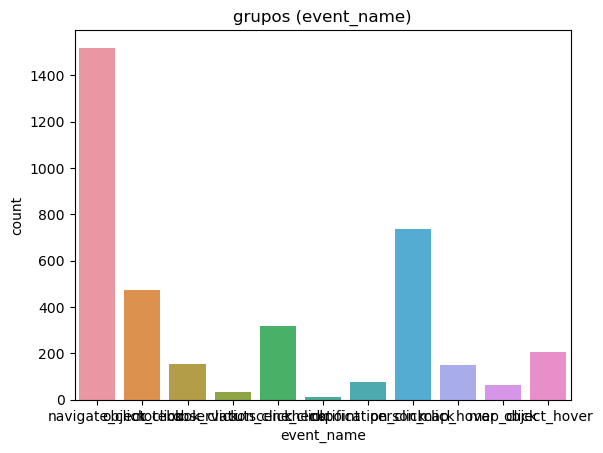

In [ ]:
df_plot = df_teste.groupBy('event_name').count().toPandas()
plotBar(df_plot, 'event_name', 'count')
plt.title('grupos (event_name)')
plt.show()

In [ ]:
df_train.printSchema()
df_train.show(1, vertical=True)
train_count = df_train.count()
train_count
df_train.show(1)

root
 |-- session_id: long (nullable = true)
 |-- index: integer (nullable = true)
 |-- elapsed_time: integer (nullable = true)
 |-- event_name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- page: double (nullable = true)
 |-- room_coor_x: double (nullable = true)
 |-- room_coor_y: double (nullable = true)
 |-- screen_coor_x: double (nullable = true)
 |-- screen_coor_y: double (nullable = true)
 |-- hover_duration: double (nullable = true)
 |-- text: string (nullable = true)
 |-- fqid: string (nullable = true)
 |-- room_fqid: string (nullable = true)
 |-- text_fqid: string (nullable = true)
 |-- fullscreen: string (nullable = true)
 |-- hq: string (nullable = true)
 |-- music: string (nullable = true)
 |-- level_group: string (nullable = true)

-RECORD 0------------------------------
 session_id     | 20090312431273200    
 index          | 0                    
 elapsed_time   | 0                    
 event_name     | cutscene_

+-----------------+-----+------------+--------------+-----+-----+----+-------------------+-------------------+-------------+-------------+--------------+---------+-----+--------------------+--------------------+----------+----+-----+-----------+
|       session_id|index|elapsed_time|    event_name| name|level|page|        room_coor_x|        room_coor_y|screen_coor_x|screen_coor_y|hover_duration|     text| fqid|           room_fqid|           text_fqid|fullscreen|  hq|music|level_group|
+-----------------+-----+------------+--------------+-----+-----+----+-------------------+-------------------+-------------+-------------+--------------+---------+-----+--------------------+--------------------+----------+----+-----+-----------+
|20090312431273200|    0|           0|cutscene_click|basic|    0|null|-413.99140522263224|-159.31468617022784|        380.0|        494.0|          null|undefined|intro|tunic.historicals...|tunic.historicals...|      null|null| null|        0-4|
+---------------

In [ ]:
df_train_labs.show(5)

+--------------------+-------+
|          session_id|correct|
+--------------------+-------+
|20090312431273200_q1|      1|
|20090312433251036_q1|      0|
|20090314121766812_q1|      1|
|20090314363702160_q1|      1|
|20090314441803444_q1|      1|
+--------------------+-------+
only showing top 5 rows



In [ ]:
print('\nNulls in all columns')
cols_to_forget = ['Credit Limit']
teste_cols_interest = [x for x in df_teste.columns]
for cl in teste_cols_interest:
    k = df_teste.select(cl).filter(F.col(cl).isNull() | F.isnan(cl)).count()
    if k > 0:
        print(f'Column {cl} with {k} nulls or NaN, out of {teste_count} records ({k*100/teste_count:.2f}%)')


Nulls in all columns
Column page with 3575 nulls or NaN, out of 3728 records (95.90%)
Column room_coor_x with 362 nulls or NaN, out of 3728 records (9.71%)
Column room_coor_y with 362 nulls or NaN, out of 3728 records (9.71%)
Column screen_coor_x with 362 nulls or NaN, out of 3728 records (9.71%)
Column screen_coor_y with 362 nulls or NaN, out of 3728 records (9.71%)
Column hover_duration with 3375 nulls or NaN, out of 3728 records (90.53%)
Column text with 2566 nulls or NaN, out of 3728 records (68.83%)
Column fqid with 1226 nulls or NaN, out of 3728 records (32.89%)
Column room_fqid with 6 nulls or NaN, out of 3728 records (0.16%)
Column text_fqid with 2572 nulls or NaN, out of 3728 records (68.99%)
Column fullscreen with 3728 nulls or NaN, out of 3728 records (100.00%)
Column hq with 3728 nulls or NaN, out of 3728 records (100.00%)
Column music with 3728 nulls or NaN, out of 3728 records (100.00%)
Column level_group with 6 nulls or NaN, out of 3728 records (0.16%)
Column session_le

In [ ]:
test

NameError: name 'test' is not defined

In [ ]:
print('\nNulls in all columns')
cols_to_forget = ['Credit Limit']
train_cols_interest = [x for x in df_train.columns]
for cl in train_cols_interest:
    k = df_train.select(cl).filter(F.col(cl).isNull() | F.isnan(cl)).count()
    if k > 0:
        print(f'Column {cl} with {k} nulls or NaN, out of {train_count} records ({k*100/train_count:.2f}%)')

In [ ]:
df_train.head(4)

In [ ]:
df_train.tail(4)

In [ ]:
train_cols_interest.remove('fullscreen')
train_cols_interest.remove('music')
train_cols_interest.remove('hq')
train_cols_interest.remove('page')
train_cols_interest.remove('hover_duration')
train_cols_interest.remove('text')
train_cols_interest.remove('text_fqid')

In [ ]:
for cl in train_cols_interest:
    k = df_train.select(cl).filter(F.col(cl).isNull() | F.isnan(cl)).count()
    if k > 0:
        print(f'Column {cl} with {k} nulls or NaN, out of {train_count} records ({k*100/train_count:.2f}%)')

In [ ]:
teste_cols_interest.remove('fullscreen')
teste_cols_interest.remove('music')
teste_cols_interest.remove('hq')
teste_cols_interest.remove('page')

In [ ]:
for cl in teste_cols_interest:
    k = df_teste.select(cl).filter(F.col(cl).isNull() | F.isnan(cl)).count()
    if k > 0:
        print(f'Column {cl} with {k} nulls or NaN, out of {teste_count} records ({k*100/teste_count:.2f}%)')

In [ ]:
print('\nUniqueness in teste:')
for cl in teste_cols_interest:
    k = df_teste.select(cl).distinct().count()
    print(f"Columns {cl} with {k} distinct values, out of {teste_count}"+f" records ({k*100/teste_count:.2f})%")

In [ ]:
print('\nUniqueness in treino:')
for cl in train_cols_interest:
    k = df_train.select(cl).distinct().count()
    print(f"Columns {cl} with {k} distinct values, out of {train_count}"+f" records ({k*100/train_count:.2f})%")

In [ ]:
#corr_matrix = Correlation.corr(df_teste, df_teste).collect()[0][0].toArray().tolist()

In [ ]:
#df_plot = pd.DataFrame(data = corr_matrix, index=df.teste.columns, columns=df.teste.columns)
#plotCorrelationMatrix_1(df_plot, annot=True)
#plt.title('Correlations among numerical features')
#plt.show()

In [ ]:
seed = 5
with_replacement = False
fraction = 0.2          # reduce to 20%
small_df_train = df_train.sample(withReplacement=with_replacement, 
                                               fraction=fraction, seed=seed)

In [ ]:
small_df_train.count()

2634650

In [ ]:
df_train.count()

13174211

In [ ]:
small_df_train.write.mode("overwrite").parquet("small-df_train")

In [ ]:
df_train_clean = spark.read.parquet('small-df_train')

In [ ]:
df_train_clean.toPandas()

ERROR:root:Exception while sending command.                                     
Traceback (most recent call last):
  File "/home/kardec/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/kardec/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/kardec/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,21050410434308160,968,1726999,person_click,basic,20,NaN,-381.847136,110.712177,254.0,245.0,NaN,It has something to do with ecology.,worker,tunic.library.frontdesk,tunic.library.frontdesk.worker.flag,None,None,None,13-22
1,21050410434308160,978,1735199,navigate_click,undefined,20,NaN,586.732639,227.529868,762.0,155.0,NaN,None,tomicrofiche,tunic.library.frontdesk,None,None,None,None,13-22
2,21050410434308160,985,1754449,object_click,basic,20,NaN,32.837203,-229.000000,480.0,559.0,NaN,None,reader_flag.paper1.next,tunic.library.microfiche,None,None,None,None,13-22
3,21050410434308160,986,1758732,object_hover,undefined,20,NaN,NaN,NaN,NaN,NaN,10699.0,None,reader_flag.paper0.next,tunic.library.microfiche,None,None,None,None,13-22
4,21050410434308160,987,1759332,object_hover,undefined,20,NaN,NaN,NaN,NaN,NaN,566.0,None,reader_flag.paper2.bingo,tunic.library.microfiche,None,None,None,None,13-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634645,22100221145014656,1570,5431389,object_click,basic,21,NaN,-257.274472,45.755580,107.0,286.0,NaN,None,journals_flag.hub.topics,tunic.historicalsociety.stacks,None,None,None,None,13-22
2634646,22100221145014656,1584,5445520,object_hover,undefined,21,NaN,NaN,NaN,NaN,NaN,404.0,None,journals_flag.pic_1.next,tunic.historicalsociety.stacks,None,None,None,None,13-22
2634647,22100221145014656,1586,5447903,object_click,basic,21,NaN,447.725528,-72.244420,812.0,404.0,NaN,None,journals_flag.pic_2.next,tunic.historicalsociety.stacks,None,None,None,None,13-22
2634648,22100221145014656,1590,5470870,navigate_click,undefined,22,NaN,10.725528,-282.244420,375.0,614.0,NaN,None,toentry,tunic.historicalsociety.stacks,None,None,None,None,13-22


In [ ]:
df_train_on = df_train.select(train_cols_interest)
df_teste_on = df_teste.select(teste_cols_interest)

In [ ]:
df_train_on.printSchema()
df_teste_on.printSchema()

root
 |-- session_id: long (nullable = true)
 |-- index: integer (nullable = true)
 |-- elapsed_time: integer (nullable = true)
 |-- event_name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- room_coor_x: double (nullable = true)
 |-- room_coor_y: double (nullable = true)
 |-- screen_coor_x: double (nullable = true)
 |-- screen_coor_y: double (nullable = true)
 |-- fqid: string (nullable = true)
 |-- room_fqid: string (nullable = true)
 |-- level_group: string (nullable = true)

root
 |-- session_id: long (nullable = true)
 |-- index: integer (nullable = true)
 |-- elapsed_time: integer (nullable = true)
 |-- event_name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- room_coor_x: double (nullable = true)
 |-- room_coor_y: double (nullable = true)
 |-- screen_coor_x: double (nullable = true)
 |-- screen_coor_y: double (nullable = true)
 |-- hover_duration: double (nullable =